# Social Relationships RSA
This analysis will explore whether dimensions related to social relationship knowledge are represented in a netowkr of brain regionswhich were reliabily activated during a task about social relationships. In this analysis, I will use the reliability network mask as an ROI for a neural RDM, and the PCA scores for each relationship to create four theoretical model RDMs.

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask
from nltools.stats import fdr, threshold, fisher_r_to_z, one_sample_permutation
from sklearn.metrics import pairwise_distances
from nilearn.plotting import plot_glass_brain, plot_stat_map

In [2]:
bids_dir = '/data/projects/relationship_knowledge/'
os.chdir(bids_dir)

output_dir = os.path.join(bids_dir, 'derivatives', 'rsa_theory_comps')
data_dir = os.path.join(bids_dir, 'derivatives','relscenarios_all')

if os.path.isfile(output_dir):
    print('Output directory already exists. Continuing will overwrite data.')
#else:
#    os.makedirs(output_dir)

# Single Subject Pattern Similarity
First I will run the analysis on a single subject to give an example of the steps of the analysis

In [3]:
subjs_scan_info = pd.read_csv(bids_dir+'derivatives/rsa_neurora/mriqc_summary_poor.csv')

subjs_list = list(subjs_scan_info['subject'].unique())
len(subjs_list)

subjs_list.sort()
print('Found '+str(len(subjs_list))+' subjects')
subj = subjs_list[0]

file_list = glob.glob(os.path.join(data_dir, subj, f'beta*nii'))
file_list.sort()
file_list = file_list[:-2]
print('Found '+str(len(file_list))+' beta maps')

conditions = [os.path.basename(x)[:-4].split('beta_')[-1] for x in file_list]

beta = Brain_Data(file_list)

Found 36 subjects
Found 76 beta maps


### fMRI task conditions

In [4]:
conditions = pd.read_csv(bids_dir+'/derivatives/fmriprep/'+subj+'/ses-001/func/'+subj+'_ses-001_task-relscenarios_run-all_cat_desc-design_matrix.csv')
conditions = conditions.columns.tolist()[:76]
conditions = [x[:-3] for x in conditions]
conditions = [x.rstrip() for x in conditions]
print(conditions)

['A Person and their Family Friends', 'A Person and their In-Laws', 'A Person and their Social Media Follower', 'Ancestor and Descendant', 'Athletic Trainer and Trainee', 'Between Business Partners', 'Between Business Rivals', 'Between Casual Acquaintances', 'Between Childhood Friends', 'Between Church Members', 'Between Classmates', 'Between Close Friends', 'Between Distant Relatives', 'Between Divorced Spouses', 'Between Enemies', 'Between Fans of Opposing Sports Teams', 'Between Fans of the Same Sports Team', 'Between Friends with Benefits', 'Between Life-Partners', 'Between Opposing Negotiators', 'Between Peers', 'Between Pen-Friends', 'Between Political Opponents', 'Between Religious Followers', 'Between Second Cousins', 'Between Siblings', 'Between Soul-Mates', 'Between Step-Siblings', 'Between Teammates in Sports', 'Between Twins', 'Bride and Bridesmaid', 'Bully and Victim', 'Criminal and Police Officer', 'Criminal and Prosecutor', 'Customer and Businessman', 'Director and Perfo

## Reliability network mask
This mask was created by a reliability analysis that shows the voxels that were reliabily activated during the task. This method of find reliable voxels is agnostic to the type of trial in the task. More information [here](https://www.sciencedirect.com/science/article/pii/S1053811919309413)

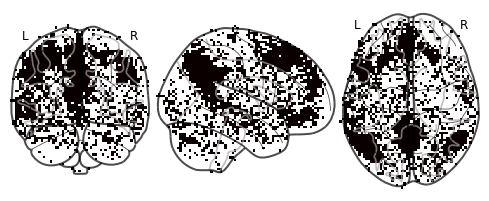

In [5]:
mask = Brain_Data(os.path.join(bids_dir, 'derivatives', 'reliability_analysis', '3-Results', 'relscenarios', 'Step1-Reliability', 'group_relb_bin.nii.gz'), mask="derivatives/fmriprep/sub-301/ses-001/func/sub-301_ses-001_task-relscenarios_run-001_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz")
#mask = Brain_Data(os.path.join(bids_dir, 'derivatives', 'rsa_theory_comps', 'relb_map_sm_thr.nii.gz'))
#mask_x = expand_mask(mask)
#image.smo

plot_glass_brain(mask.to_nifti())

### Smooth network mask

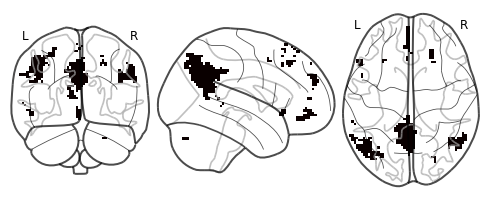

In [6]:
from nilearn.image import math_img, smooth_img
from nilearn.masking import compute_epi_mask

relb_map = Brain_Data(os.path.join(bids_dir, 'derivatives', 'reliability_analysis', '3-Results', 'relscenarios', 'Step1-Reliability', 'group_relb.nii'), mask="derivatives/fmriprep/sub-301/ses-001/func/sub-301_ses-001_task-relscenarios_run-001_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz")

relb_map_sm = smooth_img(relb_map.to_nifti(), 4)

relb_map_sm_bin = math_img('img > 0.3', img=relb_map_sm)

plot_glass_brain(relb_map_sm_bin)
relb_map_sm_bin.to_filename(output_dir+'/relb_map_sm_bin.nii.gz')

## Create a neural RDM for a single subject, using the group reliability mask as an ROI.

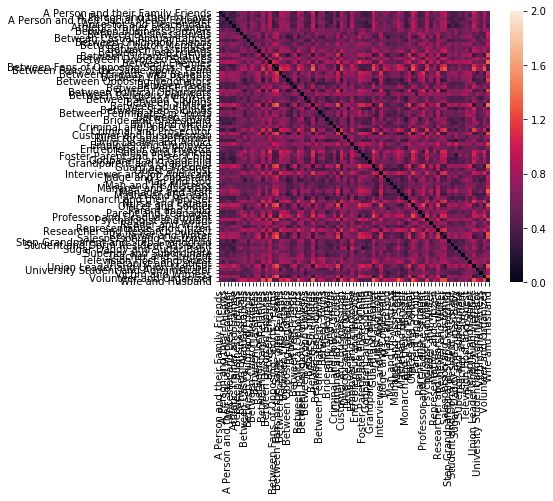

In [7]:
out = beta.apply_mask(relb_map_sm_bin).distance(method='correlation')

out.labels = conditions
f2 = out.plot(vmin=0, vmax=2)

### 76 Task relationships plotted on the first three dimensions from an MDS analysis of the neural data

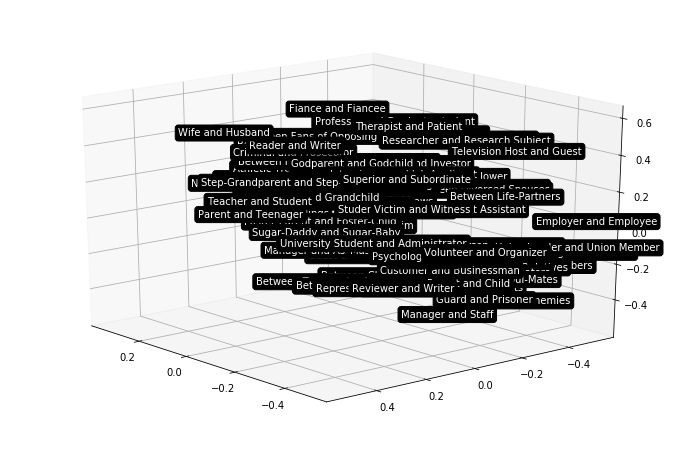

In [8]:
f = out.plot_mds(n_components=3, view=(20, 140))

## Import and fix theoretical component RDMs

### Component 1 - Formality

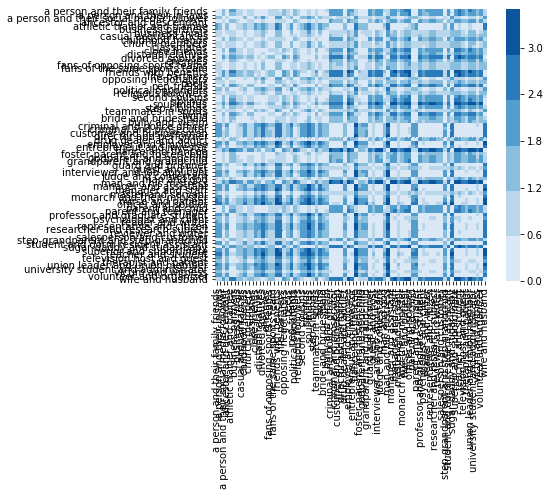

In [9]:
# Import distance matrix from theoretical components analysis
comp1_dist = pd.read_csv(bids_dir+'derivatives/lit_dimensions_pca/results/comp1_dist_matrix.csv', index_col=0)

# Make conditions list and the columns/rows of the distance matrix lowercase
conditions = [x.lower() for x in conditions]
comp1_dist.columns = [x.lower() for x in comp1_dist.columns]
comp1_dist.index = [x.lower() for x in comp1_dist.index]

# Fix up the conditions lists and the columns/rows of the matrix so that they match
## There were some small typos and string differences between the two
comp1_dist.columns = comp1_dist.columns.str.replace('–','and')
comp1_dist.index = comp1_dist.index.str.replace('–','and')
comp1_dist.columns = comp1_dist.columns.str.replace(' - ',' and ')
comp1_dist.index = comp1_dist.index.str.replace(' - ',' and ')
comp1_dist.columns = comp1_dist.columns.str.replace('  ',' ')
comp1_dist.index = comp1_dist.index.str.replace('  ',' ')
comp1_dist.columns = comp1_dist.columns.str.replace('between ','')
comp1_dist.index = comp1_dist.index.str.replace('between ','')
comp1_dist = comp1_dist.rename(columns = {'a monarch and their minister': 'monarch and their minister',
                                             'researcher and research-subject': 'researcher and research subject',
                                              'union-leader and union-member': 'union leader and union member',
                                              'monarch and minister': 'monarch and their minister',
                                              'person and family friends': 'a person and their family friends',
                                              'friends-with-benefits': 'friends with benefits',
                                              'childhood-friends': 'childhood friends',
                                              'distant-relatives': 'distant relatives',
                                              'close-friends': 'close friends',
                                              'person and their social media follower': 'a person and their social media follower',
                                              'student and dorm-resident-assistant': 'student and dorm resident assistant',
                                              'second-cousins': 'second cousins'}, 
                                   index = {'a monarch and their minister': 'monarch and their minister',
                                             'researcher and research-subject': 'researcher and research subject',
                                              'union-leader and union-member': 'union leader and union member',
                                              'monarch and minister': 'monarch and their minister',
                                              'person and family friends': 'a person and their family friends',
                                              'friends-with-benefits': 'friends with benefits',
                                              'childhood-friends': 'childhood friends',
                                              'distant-relatives': 'distant relatives',
                                              'close-friends': 'close friends',
                                              'person and their social media follower': 'a person and their social media follower',
                                              'student and dorm-resident-assistant': 'student and dorm resident assistant',
                                              'second-cousins': 'second cousins'})
conditions = [x.replace('between ','') for x in conditions]

#comp1_dist = comp1_dist[conditions].loc[conditions]
#print(comp1_dist.shape)

comp1_adj = Adjacency(comp1_dist[conditions].loc[conditions], matrix_type='distance', labels=conditions)
f = comp1_adj.plot(cmap=sns.color_palette("Blues"))

## Component 2 - Concreteness

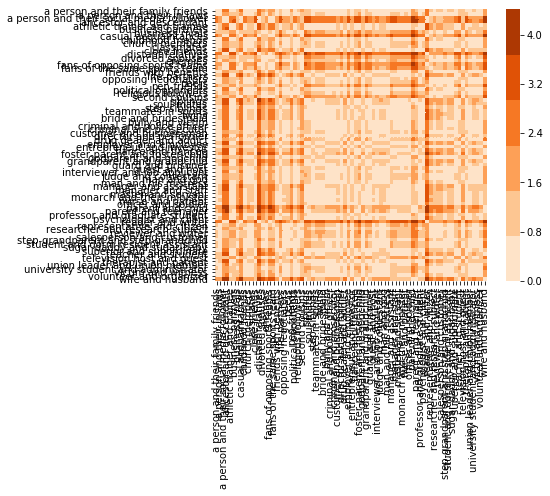

In [10]:
# Import distance matrix from theoretical components analysis
comp2_dist = pd.read_csv(bids_dir+'derivatives/lit_dimensions_pca/results/comp2_dist_matrix.csv', index_col=0)

# Make conditions list and the columns/rows of the distance matrix lowercase
comp2_dist.columns = [x.lower() for x in comp2_dist.columns]
comp2_dist.index = [x.lower() for x in comp2_dist.index]

# Fix up the conditions lists and the columns/rows of the matrix so that they match
## There were some small typos and string differences between the two
comp2_dist.columns = comp2_dist.columns.str.replace('–','and')
comp2_dist.index = comp2_dist.index.str.replace('–','and')
comp2_dist.columns = comp2_dist.columns.str.replace(' - ',' and ')
comp2_dist.index = comp2_dist.index.str.replace(' - ',' and ')
comp2_dist.columns = comp2_dist.columns.str.replace('  ',' ')
comp2_dist.index = comp2_dist.index.str.replace('  ',' ')
comp2_dist.columns = comp2_dist.columns.str.replace('between ','')
comp2_dist.index = comp2_dist.index.str.replace('between ','')
comp2_dist = comp2_dist.rename(columns = {'a monarch and their minister': 'monarch and their minister'}, 
                               index = {'a monarch and their minister': 'monarch and their minister'})

comp2_adj = Adjacency(comp2_dist[conditions].loc[conditions], matrix_type='distance', labels=conditions)
f = comp2_adj.plot(cmap = sns.color_palette("Oranges"))


### Component 3 - Conflict & Coercion

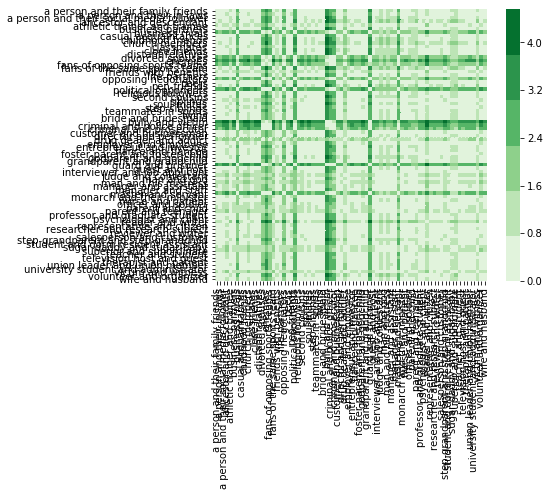

In [11]:
# Import distance matrix from theoretical components analysis
comp3_dist = pd.read_csv(bids_dir+'derivatives/lit_dimensions_pca/results/comp3_dist_matrix.csv', index_col=0)

# Make conditions list and the columns/rows of the distance matrix lowercase
comp3_dist.columns = [x.lower() for x in comp3_dist.columns]
comp3_dist.index = [x.lower() for x in comp3_dist.index]

# Fix up the conditions lists and the columns/rows of the matrix so that they match
## There were some small typos and string differences between the two
comp3_dist.columns = comp3_dist.columns.str.replace('–','and')
comp3_dist.index = comp3_dist.index.str.replace('–','and')
comp3_dist.columns = comp3_dist.columns.str.replace(' - ',' and ')
comp3_dist.index = comp3_dist.index.str.replace(' - ',' and ')
comp3_dist.columns = comp3_dist.columns.str.replace('  ',' ')
comp3_dist.index = comp3_dist.index.str.replace('  ',' ')
comp3_dist.columns = comp3_dist.columns.str.replace('between ','')
comp3_dist.index = comp3_dist.index.str.replace('between ','')
comp3_dist = comp3_dist.rename(columns = {'a monarch and their minister': 'monarch and their minister'}, 
                               index = {'a monarch and their minister': 'monarch and their minister'})

comp3_adj = Adjacency(comp3_dist[conditions].loc[conditions], matrix_type='distance', labels=conditions)
f = comp3_adj.plot(cmap=sns.color_palette("Greens"))

### Component 4 - Societal Importance

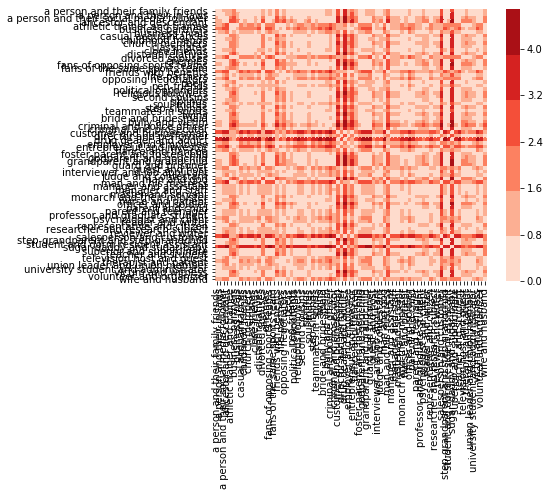

In [12]:
# Import distance matrix from theoretical components analysis
comp4_dist = pd.read_csv(bids_dir+'derivatives/lit_dimensions_pca/results/comp4_dist_matrix.csv', index_col=0)

# Make conditions list and the columns/rows of the distance matrix lowercase
comp4_dist.columns = [x.lower() for x in comp4_dist.columns]
comp4_dist.index = [x.lower() for x in comp4_dist.index]

# Fix up the conditions lists and the columns/rows of the matrix so that they match
## There were some small typos and string differences between the two
comp4_dist.columns = comp4_dist.columns.str.replace('–','and')
comp4_dist.index = comp4_dist.index.str.replace('–','and')
comp4_dist.columns = comp4_dist.columns.str.replace(' - ',' and ')
comp4_dist.index = comp4_dist.index.str.replace(' - ',' and ')
comp4_dist.columns = comp4_dist.columns.str.replace('  ',' ')
comp4_dist.index = comp4_dist.index.str.replace('  ',' ')
comp4_dist.columns = comp4_dist.columns.str.replace('between ','')
comp4_dist.index = comp4_dist.index.str.replace('between ','')
comp4_dist = comp4_dist.rename(columns = {'a monarch and their minister': 'monarch and their minister'}, 
                               index = {'a monarch and their minister': 'monarch and their minister'})

comp4_adj = Adjacency(comp4_dist[conditions].loc[conditions], matrix_type='distance', labels=conditions)
f = comp4_adj.plot(cmap=sns.color_palette("Reds"))

# Single subject RSA
Find the similarity between the neural RDM for a single subject and the theoretical RDMs

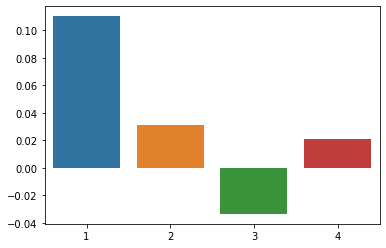

In [13]:
out_sims = []
for comp in [comp1_adj, comp2_adj, comp3_adj, comp4_adj]:
    s = out.similarity(comp, metric='spearman', n_permute=0)
    out_sims.append(s['correlation'])

sns.barplot(x=[1, 2, 3, 4], y=out_sims)

In [14]:
from scipy.stats import spearmanr

# compute the correlation
spearmanr(out.data,comp1_adj.data)

SpearmanrResult(correlation=0.11007438577967849, pvalue=3.8225010859497975e-09)

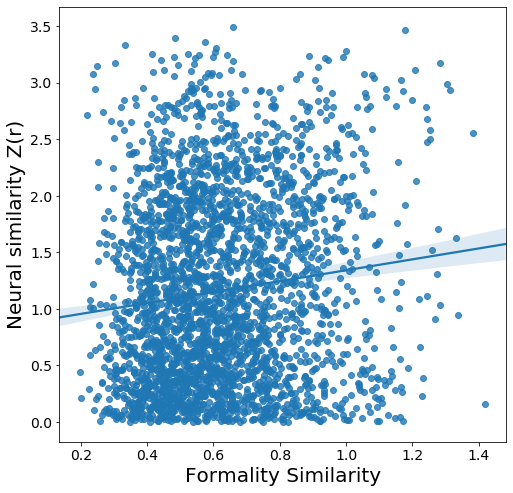

In [15]:
# generate a scatterplot to go with it
plt.figure(figsize=(8, 8))
fig = sns.regplot(x=out.data,y=comp1_adj.data)
fig.set_xlabel('Formality Similarity',fontsize=20)
fig.set_ylabel('Neural similarity Z(r)',fontsize=20)
fig.tick_params(labelsize=14)

# Group RSA

## Subject Level
Correlate each subjects neural RDM with the theoretical RDMs

In [16]:
all_sub_dissim = {}; all_sub_comp1_rsa = {}; all_sub_comp2_rsa = {}; all_sub_comp3_rsa = {}; all_sub_comp4_rsa = {};
for subj in subjs_list:
    file_list = glob.glob(os.path.join(data_dir, subj, f'beta*nii'))
    file_list.sort()
    file_list = file_list[:-2]
    print('Calculating dissimilarities for '+subj)

    #conditions = [os.path.basename(x)[:-7].split('_beta_')[-1] for x in file_list]

    beta = Brain_Data(file_list)
    
    #sub_pattern = []; motor_left_sim_r = [];
    
    sub_pattern_dissim = beta.apply_mask(mask).distance(method='correlation')
    #sub_pattern_similarity.data = 1 - sub_pattern_similarity.data
    sub_pattern_dissim.labels = conditions
    s_comp1 = sub_pattern_dissim.similarity(comp1_adj, metric='spearman', n_permute=0)
    s_comp2 = sub_pattern_dissim.similarity(comp2_adj, metric='spearman', n_permute=0)
    s_comp3 = sub_pattern_dissim.similarity(comp3_adj, metric='spearman', n_permute=0)
    s_comp4 = sub_pattern_dissim.similarity(comp4_adj, metric='spearman', n_permute=0)

    #sub_pattern.append(sub_pattern_similarity)
    #motor_left_sim_r.append(s['correlation'])
    
    all_sub_dissim[subj] = sub_pattern_dissim
    all_sub_comp1_rsa[subj] = s_comp1['correlation']
    all_sub_comp2_rsa[subj] = s_comp2['correlation']
    all_sub_comp3_rsa[subj] = s_comp3['correlation']
    all_sub_comp4_rsa[subj] = s_comp4['correlation']
all_sub_comp1_rsa = pd.DataFrame(all_sub_comp1_rsa, index=['r', 'p']).T
all_sub_comp2_rsa = pd.DataFrame(all_sub_comp2_rsa, index=['r', 'p']).T
all_sub_comp3_rsa = pd.DataFrame(all_sub_comp3_rsa, index=['r', 'p']).T
all_sub_comp4_rsa = pd.DataFrame(all_sub_comp4_rsa, index=['r', 'p']).T

Calculating dissimilarities for sub-301
Calculating dissimilarities for sub-651
Calculating dissimilarities for sub-653
Calculating dissimilarities for sub-693
Calculating dissimilarities for sub-697
Calculating dissimilarities for sub-699
Calculating dissimilarities for sub-700
Calculating dissimilarities for sub-701
Calculating dissimilarities for sub-706
Calculating dissimilarities for sub-715
Calculating dissimilarities for sub-716
Calculating dissimilarities for sub-720
Calculating dissimilarities for sub-721
Calculating dissimilarities for sub-722
Calculating dissimilarities for sub-723
Calculating dissimilarities for sub-724
Calculating dissimilarities for sub-726
Calculating dissimilarities for sub-727
Calculating dissimilarities for sub-730
Calculating dissimilarities for sub-738
Calculating dissimilarities for sub-739
Calculating dissimilarities for sub-740
Calculating dissimilarities for sub-743
Calculating dissimilarities for sub-745
Calculating dissimilarities for sub-747


### Plot subject-level similarity

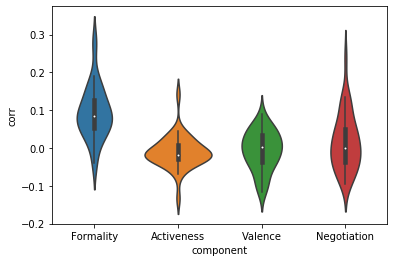

In [24]:
rsa_df = pd.DataFrame(np.column_stack((all_sub_comp1_rsa['r'], all_sub_comp2_rsa['r'], 
                       all_sub_comp3_rsa['r'], all_sub_comp4_rsa['r'])), columns=['Formality', 'Activeness', 'Valence', 'Negotiation'])
rsa_df_melt = rsa_df.melt(var_name='component', value_name='corr')

sns.violinplot(x='component', y='corr', data=rsa_df_melt)
plt.savefig(output_dir+'/roi_subject-level_violinplot.png')

### Significance Test
One-sample t-test permutation

In [18]:
rsa_stats = []

rsa_stats.append(one_sample_permutation(fisher_r_to_z(all_sub_comp1_rsa['r'])))
rsa_stats.append(one_sample_permutation(fisher_r_to_z(all_sub_comp2_rsa['r'])))
rsa_stats.append(one_sample_permutation(fisher_r_to_z(all_sub_comp3_rsa['r'])))
rsa_stats.append(one_sample_permutation(fisher_r_to_z(all_sub_comp4_rsa['r'])))
rsa_stats



[{'mean': 0.09517152788188186, 'p': 0.0001999600079984003},
 {'mean': -0.010609731039132398, 'p': 0.15036992601479704},
 {'mean': -0.006698761493289732, 'p': 0.4381123775244951},
 {'mean': 0.01629013703897403, 'p': 0.1947610477904419}]

0.0001999600079984003


/opt/anaconda3/lib/python3.7/site-packages/nilearn/plotting/displays.py:780: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


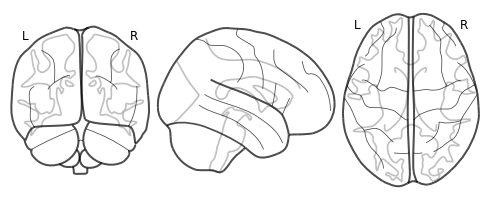

In [23]:
fdr_p = fdr(np.array([x['p'] for x in rsa_stats]), q=0.05)
print(fdr_p)

rsa_model_r = Brain_Data([x*y['mean'] for x,y in zip([mask, mask, mask, mask], rsa_stats)]).sum()
rsa_model_p = Brain_Data([x*y['p'] for x,y in zip([mask, mask, mask, mask], rsa_stats)]).sum()

thresholded = threshold(rsa_model_r, rsa_model_p, thr=fdr_p)

plot_glass_brain(thresholded.to_nifti(), cmap='coolwarm')

***

## Group Level Similarity

In [25]:
all_sub_dissim_adj = []
for subj in all_sub_dissim.keys():
    all_sub_dissim_adj.append(all_sub_dissim[subj].data)

all_sub_dissim_adj = np.asarray(all_sub_dissim_adj)
all_sub_dissim_adj.shape

(36, 2850)

In [26]:
all_sub_dissim_mean = np.mean(all_sub_dissim_adj, axis=0)
all_sub_dissim_mean.shape

(2850,)

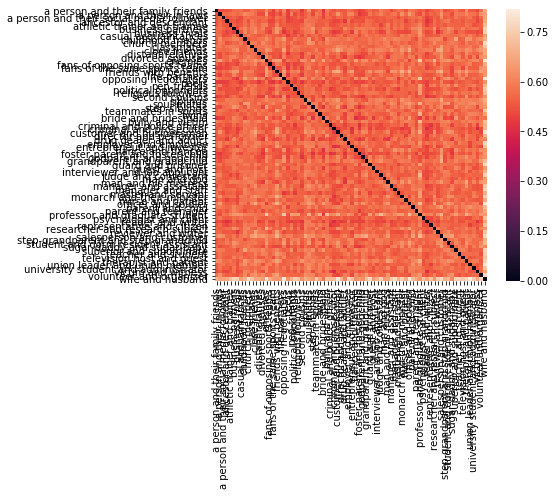

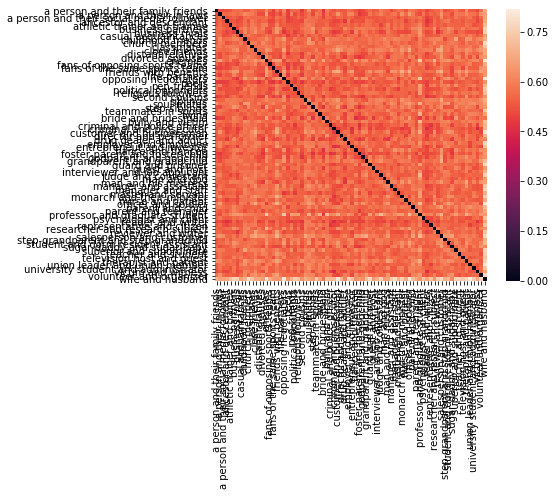

In [39]:
all_sub_dissim_mean_adj = all_sub_dissim['sub-301']
all_sub_dissim_mean_adj.data = all_sub_dissim_mean
all_sub_dissim_mean_adj.plot()

Not sure why two plots are being displayed

In [49]:
print(all_sub_dissim_mean_adj.similarity(comp1_adj, metric='spearman', n_permute=0))
print(all_sub_dissim_mean_adj.similarity(comp2_adj, metric='spearman', n_permute=0))
print(all_sub_dissim_mean_adj.similarity(comp3_adj, metric='spearman', n_permute=0))
print(all_sub_dissim_mean_adj.similarity(comp4_adj, metric='spearman', n_permute=0))

{'correlation': 0.32144239897235155, 'p': 1.0}
{'correlation': -0.05845139168700616, 'p': 1.0}
{'correlation': -0.03354593081189474, 'p': 1.0}
{'correlation': 0.045584902924709826, 'p': 1.0}


# Mark's RSA Workshop
The following code was adapted from [Mark Thornton's RSA workshop](https://colab.research.google.com/drive/1UEtFr-oJisRzl8BmzbNdMZZ7-Of0gLcH?usp=sharing)

In [50]:
all_sub_dissim_df = pd.DataFrame(all_sub_dissim_adj.T, columns=subjs_list)

for col in all_sub_dissim_df:
    all_sub_dissim_df[col] = all_sub_dissim_df[col].to_list()
    
all_sub_dissim_df

,sub-301,sub-651,sub-653,sub-693,sub-697,sub-699,sub-700,sub-701,sub-706,sub-715,...,sub-751,sub-754,sub-759,sub-761,sub-762,sub-763,sub-764,sub-765,sub-766,sub-767
0,0.328389,0.368626,0.664292,0.396863,0.696448,0.686069,0.421727,0.607946,0.200366,0.524274,...,0.272365,0.681620,0.451324,0.445701,0.758082,0.469047,0.379045,0.303186,0.395772,0.582130
1,0.415191,0.322192,0.731423,0.418532,0.646442,0.555058,0.294137,0.296208,0.533392,0.457112,...,0.387884,0.686152,0.362694,0.618021,0.670560,0.732540,0.378266,0.500591,0.956052,0.440427
2,0.321267,0.333351,0.536208,0.548126,1.002953,0.529415,0.329871,0.536556,0.324854,0.322419,...,0.454162,0.580005,0.440065,0.374462,0.618739,0.496351,0.397453,0.485123,0.609608,0.594198
3,0.335873,0.427580,0.442202,0.443803,0.780600,0.586307,0.367162,0.276265,0.494822,0.344340,...,0.483905,0.695900,0.438153,0.421014,0.941215,0.615147,0.515598,0.416100,0.520268,0.448851
4,0.510471,0.456869,0.435338,0.591135,0.735821,0.617408,0.334031,0.425823,0.372798,0.418210,...,0.509511,0.641312,0.384485,0.612680,0.710737,0.731770,0.467868,0.594903,0.647733,0.594054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2845,0.334950,0.458592,0.577144,0.543422,0.711113,0.616950,0.223226,0.757514,0.560311,0.621231,...,0.614616,0.818710,0.433153,0.551455,0.564302,0.481285,0.562630,0.354093,0.642039,0.611892
2846,0.972021,0.704936,0.360883,0.796968,0.467739,0.823862,1.193696,0.543736,0.533752,0.718616,...,0.824611,1.297168,0.787153,0.677338,0.603963,0.880785,0.579703,0.682975,0.564332,0.442915
2847,0.342424,0.509165,0.542849,0.576045,0.624655,0.424025,0.288679,0.707646,0.504193,0.363975,...,0.453659,0.553179,0.578083,0.686937,0.709583,0.479080,0.582423,0.361865,0.584360,0.633318
2848,0.909728,0.646347,0.549844,0.667563,0.661722,0.722972,1.038203,0.470594,0.498250,0.779275,...,0.749112,0.653370,0.899363,0.621198,0.685886,0.901162,0.438625,0.616800,0.503262,0.478606


## Correlate model and neural data

In [51]:
from scipy.stats import spearmanr, ttest_1samp

# correlate pairwise similarity ratings with each participants' neural pattern similarity
ncors = []

for subj in subjs_list:
    ncors.append(spearmanr(all_sub_dissim_df[subj], comp1_adj.data).correlation)

Fisher transform correlations

In [52]:
zncors = np.arctanh(ncors)
zncors

array([ 0.12160636,  0.19231713,  0.05670721,  0.16234153,  0.02058982,
        0.2877224 ,  0.15450155,  0.04600151,  0.07223364,  0.10659633,
        0.07925113,  0.06892364,  0.07678171,  0.09717425, -0.04103982,
        0.01454558,  0.07067591,  0.145241  ,  0.02411045,  0.11008178,
        0.16446723,  0.08154954, -0.03612448,  0.12291804,  0.09831968,
        0.08767845,  0.06797593,  0.02889899,  0.0549789 ,  0.14626838,
        0.04671308,  0.28405448,  0.17091767,  0.0900662 ,  0.1040386 ,
        0.04709119])

### Perform one-sample t-test (vs. 0) on coefficients

In [53]:
ttest_1samp(zncors,0)

Ttest_1sampResult(statistic=7.992054930307225, pvalue=2.1028010379099626e-09)

### Bootstrapping for non-parametric approach (more robust against assumption violations)

In [54]:
import seaborn as sns

np.random.seed(1)
nboot = 5000 # set bootstrap count
bmeans = np.zeros((nboot)) # preallocate output
for i in range(nboot):
    sel = np.random.choice(len(subjs_list),len(subjs_list),replace=True) # create resampling index
    bootdat = zncors[sel] # resample data
    bmeans[i] = np.mean(bootdat) # take mean of resampled data
print(np.quantile(bmeans,(.025,.975))) # get 95% CI (percentile bootstrap)


np.diff(np.quantile(bmeans,(.025,.975)))

[0.0728247  0.11836783]


array([0.04554312])

### Mean participant correlation

In [55]:
np.tanh(np.mean(np.arctanh(ncors)))

0.09488522263223441

### Cohen's d

In [57]:
ttest_1samp(zncors,0).statistic/np.sqrt(len(subjs_list))

1.332009155051204

In [64]:
all_sub_comp1_rsa = {}; all_sub_comp2_rsa = {}; all_sub_comp3_rsa = {}; all_sub_comp4_rsa = {};


# correlate pairwise similarity ratings with each participants' neural pattern similarity
all_sub_comp1_rsa['ncors'] = []
for subj in subjs_list:
    all_sub_comp1_rsa['ncors'].append(spearmanr(all_sub_dissim_df[subj], comp1_adj.data).correlation)


# Fisher transform correlations
all_sub_comp1_rsa['zncors'] = np.arctanh(all_sub_comp1_rsa['ncors'])

# Perform one-sample t-test (vs. 0) on coefficients
all_sub_comp1_rsa['ttest'] = ttest_1samp(all_sub_comp1_rsa['zncors'],0)

# Bootstrapping for non-parametric approach (more robust against assumption violations)
np.random.seed(1)
nboot = 5000 # set bootstrap count
bmeans = np.zeros((nboot)) # preallocate output
for i in range(nboot):
    sel = np.random.choice(len(subjs_list),len(subjs_list),replace=True) # create resampling index
    bootdat = all_sub_comp1_rsa['zncors'][sel] # resample data
    bmeans[i] = np.mean(bootdat) # take mean of resampled data
all_sub_comp1_rsa['CI'] = np.quantile(bmeans,(.025,.975)) # get 95% CI (percentile bootstrap)

# Mean participant correlation
all_sub_comp1_rsa['corr_mean'] = np.tanh(np.mean(np.arctanh(all_sub_comp1_rsa['ncors'])))

# Cohen's d
all_sub_comp1_rsa['cohen_d'] = ttest_1samp(all_sub_comp1_rsa['zncors'],0).statistic/np.sqrt(len(subjs_list))



ncors = []
for subj in subjs_list:
    ncors.append(spearmanr(all_sub_dissim_df[subj], comp2_adj.data).correlation)
all_sub_comp2_rsa['ncors'] = ncors
all_sub_comp2_rsa['zncors'] = np.arctanh(all_sub_comp2_rsa['ncors'])
all_sub_comp2_rsa['ttest'] = ttest_1samp(all_sub_comp2_rsa['zncors'],0)
for i in range(nboot):
    sel = np.random.choice(len(subjs_list),len(subjs_list),replace=True) # create resampling index
    bootdat = all_sub_comp2_rsa['zncors'][sel] # resample data
    bmeans[i] = np.mean(bootdat) # take mean of resampled data
all_sub_comp2_rsa['CI'] = np.quantile(bmeans,(.025,.975)) # get 95% CI (percentile bootstrap)
all_sub_comp2_rsa['corr_mean'] = np.tanh(np.mean(np.arctanh(all_sub_comp2_rsa['ncors'])))
all_sub_comp2_rsa['cohen_d'] = ttest_1samp(all_sub_comp2_rsa['zncors'],0).statistic/np.sqrt(len(subjs_list))



ncors = []
for subj in subjs_list:
    ncors.append(spearmanr(all_sub_dissim_df[subj], comp3_adj.data).correlation)
all_sub_comp3_rsa['ncors'] = ncors
all_sub_comp3_rsa['zncors'] = np.arctanh(all_sub_comp3_rsa['ncors'])
all_sub_comp3_rsa['ttest'] = ttest_1samp(all_sub_comp3_rsa['zncors'],0)
for i in range(nboot):
    sel = np.random.choice(len(subjs_list),len(subjs_list),replace=True) # create resampling index
    bootdat = all_sub_comp3_rsa['zncors'][sel] # resample data
    bmeans[i] = np.mean(bootdat) # take mean of resampled data
all_sub_comp3_rsa['CI'] = np.quantile(bmeans,(.025,.975)) # get 95% CI (percentile bootstrap)
all_sub_comp3_rsa['corr_mean'] = np.tanh(np.mean(np.arctanh(all_sub_comp3_rsa['ncors'])))
all_sub_comp3_rsa['cohen_d'] = ttest_1samp(all_sub_comp3_rsa['zncors'],0).statistic/np.sqrt(len(subjs_list))



ncors = []
for subj in subjs_list:
    ncors.append(spearmanr(all_sub_dissim_df[subj], comp4_adj.data).correlation)
all_sub_comp4_rsa['ncors'] = ncors
all_sub_comp4_rsa['zncors'] = np.arctanh(all_sub_comp4_rsa['ncors'])
all_sub_comp4_rsa['ttest'] = ttest_1samp(all_sub_comp4_rsa['zncors'],0)
for i in range(nboot):
    sel = np.random.choice(len(subjs_list),len(subjs_list),replace=True) # create resampling index
    bootdat = all_sub_comp4_rsa['zncors'][sel] # resample data
    bmeans[i] = np.mean(bootdat) # take mean of resampled data
all_sub_comp4_rsa['CI'] = np.quantile(bmeans,(.025,.975)) # get 95% CI (percentile bootstrap)
all_sub_comp4_rsa['corr_mean'] = np.tanh(np.mean(np.arctanh(all_sub_comp4_rsa['ncors'])))
all_sub_comp4_rsa['cohen_d'] = ttest_1samp(all_sub_comp4_rsa['zncors'],0).statistic/np.sqrt(len(subjs_list))

In [68]:
all_sub_comp4_rsa['ttest']

Ttest_1sampResult(statistic=1.3119334876549908, pvalue=0.1980827137038902)

# Components & Dimensions Analysis

(30, 76)


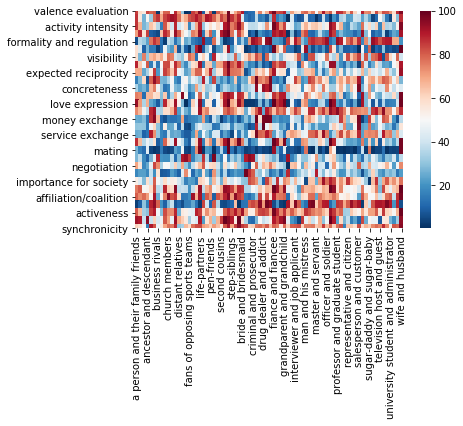

In [262]:
dim_rel = pd.read_csv('derivatives/lit_dimensions_all_relationships/results/dim_rel.csv', index_col=0)

# Make conditions list and the columns/rows of the distance matrix lowercase
dim_rel.columns = [x.lower() for x in dim_rel.columns]
dim_rel.index = [x.lower() for x in dim_rel.index]

# Fix up the conditions lists and the columns/rows of the matrix so that they match
## There were some small typos and string differences between the two
dim_rel.columns = dim_rel.columns.str.replace('–','and')
dim_rel.columns = dim_rel.columns.str.replace(' - ',' and ')
dim_rel.columns = dim_rel.columns.str.replace('  ',' ')
dim_rel.index = dim_rel.index.str.replace('  ',' ')
dim_rel.columns = dim_rel.columns.str.replace('between ','')
dim_rel = dim_rel.rename(columns = {'a monarch and their minister': 'monarch and their minister'}, 
                               index = {'a monarch and their minister': 'monarch and their minister'})
#dim_rel.columns = dim_rel.columns.str.replace('\n', '')

dim_rel = dim_rel[conditions]

print(dim_rel.shape)
sns.heatmap(dim_rel, center=50, cmap='RdBu_r')

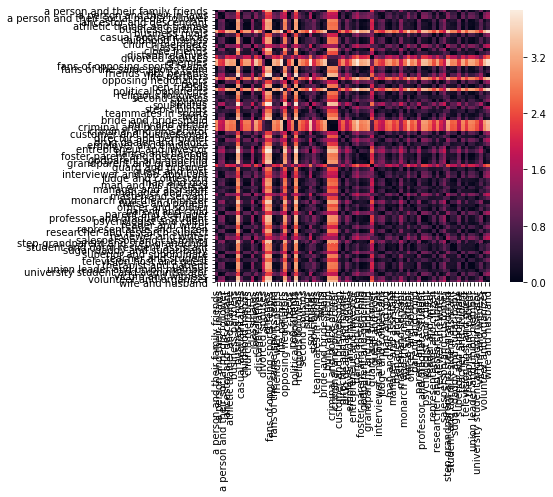

In [307]:
lit_dims = {}

for d in range (1:31)
# Import distance matrix from theoretical components analysis
dim1_dist = pd.read_csv('derivatives/lit_dimensions_all_relationships/results/dim_dist_matrices/dim1_dist_matrix.csv', index_col=0)

# Make conditions list and the columns/rows of the distance matrix lowercase
dim1_dist.columns = [x.lower() for x in comp4_dist.columns]
dim1_dist.index = [x.lower() for x in comp4_dist.index]

# Fix up the conditions lists and the columns/rows of the matrix so that they match
## There were some small typos and string differences between the two
dim1_dist.columns = dim1_dist.columns.str.replace('–','and')
dim1_dist.index = dim1_dist.index.str.replace('–','and')
dim1_dist.columns = dim1_dist.columns.str.replace(' - ',' and ')
dim1_dist.index = dim1_dist.index.str.replace(' - ',' and ')
dim1_dist.columns = dim1_dist.columns.str.replace('  ',' ')
dim1_dist.index = dim1_dist.index.str.replace('  ',' ')
dim1_dist.columns = dim1_dist.columns.str.replace('between ','')
dim1_dist.index = dim1_dist.index.str.replace('between ','')
dim1_dist = dim1_dist.rename(columns = {'a monarch and their minister': 'monarch and their minister'}, 
                               index = {'a monarch and their minister': 'monarch and their minister'})

dim1_dist = Adjacency(dim1_dist[conditions].loc[conditions], matrix_type='distance', labels=conditions)
f = dim1_dist.plot()

In [308]:
lit_dims = {}
lit_dims['dim1'] = dim1_dist
lit_dims['dim1']

nltools.data.adjacency.Adjacency(shape=(2850,), square_shape=(76, 76), Y=0, is_symmetric=True,matrix_type=distance)

# Whole-Brain Searchlight RSA